<div align="left">
  <h1>EmbedIA</h1>
  <p>EmbedIA is a machine learning framework for developing applications on microcontrollers.</p>
</div>

## Import framework from Github (run only in Colab)

In [ ]:
!pip install larq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 1.9 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/Embed-ML/EmbedIA.git

Cloning into 'EmbedIA'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (811/811), done.
remote: Compressing objects: 100% (419/419), done.
remote: Total 811 (delta 428), reused 719 (delta 347), pack-reused 0
Receiving objects: 100% (811/811), 12.17 MiB | 4.54 MiB/s, done.
Resolving deltas: 100% (428/428), done.


In [ ]:
%cd EmbedIA

/content/EmbedIA


## Load dataset 

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# 0 to not apply normalization
# 1 for normalization [-0.5, 0.5], 
# 2 for normalization z score, 
_normalize = 2 

def normalization0dot5(x):
    '''
        Normalization of values in the range [-0.5; 0.5]
        Params:
            x: numpy array to be normalized
        Return:
            x: normalized numpy array
    '''
    x = x/np.max(x)
    x = x-0.5
    return x

def z_score(X_train, x_test):
    '''
        Normalization z score, uses mean and standard deviation of train vector
        Params:
            X_train: array of train numpy to be normalized
            x_test: array of test numpy to be normalized
        Return:
            x_train, x_test: normalized numpy vectors
    '''
    x_mean= np.mean(X_train)
    x_std= np.std(X_train)
    
    x_train= (X_train-x_mean)/x_std
    x_test= (x_test-x_mean)/x_std
    return x_train, x_test

def load_dataset(_normalize):
    '''
        Load the sklearn digits dataset, applying the indicated normalization.
        Params:
            _normalize: normalization to be applied
        Return:
           X_train, X_test: training set
           y_train, y_test: test set
    '''

    digits = load_digits()
    
    if _normalize == 1:
        digits.images = normalization0dot5(digits.images)

    X_train, X_test, y_train, y_test = train_test_split(digits.images , digits.target, test_size=0.2, shuffle=True)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    if _normalize == 2:
        X_train, X_test = z_score(X_train, X_test)

    return X_train, X_test, y_train, y_test

x_train, x_test, y_train, y_test = load_dataset(_normalize)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape (1437, 8, 8, 1)
x_test.shape (360, 8, 8, 1)


## Creating and training a CNN model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, BatchNormalization

def create_model(x_train, y_train, y_test):
    '''
        Create a model
        Input parameters:
            x_train: training data
            y_train, y_test: labels of the data involved (including test data)

        return
            model: sequential layers model
    '''
    classes = max(y_test.max(),y_train.max())+1

    model = Sequential(name="EmbedIA_model")

    model.add(Conv2D(8, kernel_size=(3, 3), input_shape=x_train[0].shape,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(2, 2),activation='relu'))

    model.add(Flatten())
    model.add(Dense(16,activation='relu'))
    model.add(Dense(classes,activation='softmax'))

    model.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['acc'])
    return model

model = create_model(x_train, y_train, y_test)
model.summary()

Model: "EmbedIA_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 8)           80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 16)          528       
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                     

### Training

In [ ]:
epocas = 120
lote = 32

history = model.fit(x_train, y_train, epochs=epocas, batch_size=lote, validation_data=(x_test, y_test))

Epoch 1/120
45/45 [==============================] - 2s 11ms/step - loss: 2.1837 - acc: 0.2289 - val_loss: 2.0325 - val_acc: 0.3333
Epoch 2/120
45/45 [==============================] - 0s 6ms/step - loss: 1.7769 - acc: 0.4836 - val_loss: 1.5738 - val_acc: 0.5556
Epoch 3/120
45/45 [==============================] - 0s 7ms/step - loss: 1.2163 - acc: 0.7196 - val_loss: 0.9774 - val_acc: 0.7694
Epoch 4/120
45/45 [==============================] - 0s 7ms/step - loss: 0.7703 - acc: 0.8232 - val_loss: 0.6578 - val_acc: 0.8278
Epoch 5/120
45/45 [==============================] - 0s 8ms/step - loss: 0.5303 - acc: 0.8803 - val_loss: 0.5143 - val_acc: 0.8528
Epoch 6/120
45/45 [==============================] - 0s 7ms/step - loss: 0.4063 - acc: 0.9012 - val_loss: 0.3760 - val_acc: 0.9000
Epoch 7/120
45/45 [==============================] - 0s 9ms/step - loss: 0.3222 - acc: 0.9255 - val_loss: 0.3145 - val_acc: 0.9194
Epoch 8/120
45/45 [==============================] - 0s 8ms/step - loss: 0.2718 - 

### Plot history

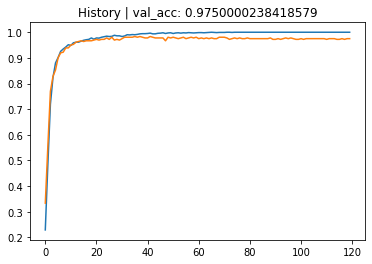

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("History | val_acc: "+str(history.history['val_acc'][len(history.history['val_acc'])-1]))
plt.show()

### Save the model

In [ ]:
model_name = "mnist_model.h5"
model.save("models/" + model_name)

## Convert model for inference in the microcontroller using EmbedIA

### Configuration and execution of the exporter

In [ ]:
import sys
# add parent folder to path in order to find EmbedIA folder
sys.path.insert(0, '..')

import joblib
from tensorflow.keras.models import load_model
from embedia.project_generator import ProjectGenerator
from embedia.model_generator.project_options import (
    ModelDataType,
    DebugMode,
    ProjectFiles,
    ProjectOptions,
    ProjectType
)


OUTPUT_FOLDER = 'outputs/'
PROJECT_NAME = 'mnist_project'

MODEL_FILE = 'models/mnist_model.h5'

model = load_model(MODEL_FILE)

model.summary()

options = ProjectOptions()

# set location of EmbedIA folder
options.embedia_folder = '../EmbedIA/embedia'


# options.project_type = ProjectType.ARDUINO
# options.project_type = ProjectType.C
options.project_type = ProjectType.CODEBLOCK
# options.project_type = ProjectType.CPP

# options.data_type = ModelDataType.FLOAT
# options.data_type = ModelDataType.FIXED32
options.data_type = ModelDataType.FIXED16
# options.data_type = ModelDataType.FIXED8

# options.debug_mode = DebugMode.DISCARD
# options.debug_mode = DebugMode.DISABLED
# options.debug_mode = DebugMode.HEADERS
options.debug_mode = DebugMode.DATA

samples = x_test[0:20]
ids = y_test[0:20]

res = model.predict(samples)
print((res*100).astype('int'))

options.example_data = samples
options.example_ids = ids

options.files = ProjectFiles.ALL
# options.files = {ProjectFiles.MAIN}
# options.files = {ProjectFiles.MODEL}
# options.files = {ProjectFiles.LIBRARY}

# if True, remove output folder and start a clean export
options.clean_output = True

############# Generate project #############

generator = ProjectGenerator(options)
generator.create_project(OUTPUT_FOLDER, PROJECT_NAME, model, options)

print("Project", PROJECT_NAME, "exported in", OUTPUT_FOLDER)

import larq
larq.models.summary(model)

Model: "EmbedIA_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 8)           80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 16)          528       
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                     

### Download generated project (Run only in Colab)

In [ ]:
from google.colab import files

!zip -r embedia_project.zip 'outputs/mnist_project'
files.download('/content/EmbedIA/embedia_project.zip')

  adding: outputs/mnist_project/ (stored 0%)
  adding: outputs/mnist_project/embedia_debug_def.h (deflated 69%)
  adding: outputs/mnist_project/embedia_debug.c (deflated 76%)
  adding: outputs/mnist_project/fixed.c (deflated 73%)
  adding: outputs/mnist_project/example_file.h (deflated 95%)
  adding: outputs/mnist_project/embedia.h (deflated 74%)
  adding: outputs/mnist_project/fixed.h (deflated 74%)
  adding: outputs/mnist_project/main.c (deflated 49%)
  adding: outputs/mnist_project/mnist_project.cbp (deflated 74%)
  adding: outputs/mnist_project/embedia.c (deflated 79%)
  adding: outputs/mnist_project/embedia_model.h (deflated 59%)
  adding: outputs/mnist_project/embedia_debug.h (deflated 55%)
  adding: outputs/mnist_project/embedia_model.c (deflated 67%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>